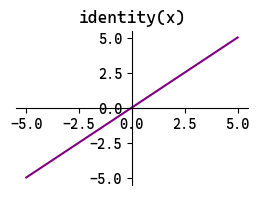

In [63]:
import torch
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Cascadia Code"]
plt.rcParams["axes.unicode_minus"] = False

x = torch.linspace(-5, 5, 1000, requires_grad=True)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2)

ax.plot(x.data, x.data, "purple")
ax.set_title("identity(x)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position("zero")
ax.spines["bottom"].set_position("zero")

plt.show()